PyTorch version: 2.1.2
CUDA version: 12.1

torch.Size([4, 1, 64, 64])
Input_BATCH_SIZE:  4
After loading:  torch.Size([1, 64, 64])
After loading:  torch.Size([1, 64, 64])
After loading:  torch.Size([1, 64, 64])
After loading:  torch.Size([1, 64, 64])


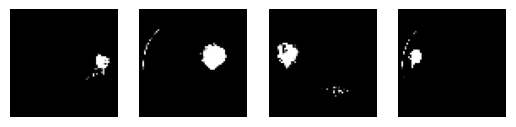

In [92]:
import os
import sys
import numpy as np
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torch.nn.functional as F
import torchvision.transforms as transforms
import torchvision.datasets as dset
import torchvision.utils as vutils
import matplotlib.pyplot as plt
from torch.autograd import Variable
import cv2

BATCH_SIZE = 4
IMAGE_CHANNEL = 3
Z_DIM = 100
G_HIDDEN = 64
X_DIM = 64
D_HIDDEN = 64
EPOCH_NUM = 2000
REAL_LABEL = 1
FAKE_LABEL = 0
lr = 0.001
seed = 1

CUDA = torch.cuda.is_available()
print(f"PyTorch version: {torch.__version__}")
if CUDA:
    print(f"CUDA version: {torch.version.cuda}\n")

torch.cuda.manual_seed(seed)

device = torch.device("cuda" if CUDA else "cpu")
cudnn.benchmark = True

transform = transforms.Compose([transforms.ToTensor()])
class cstm_Dataset():
    def __init__(self,transform=None):
        self.files=os.listdir('/kaggle/input/gan-test-data/Image_DATA/GAN_input/64x64/optic')
        #print(self.files)
        self.file_name=[]
        for file in self.files:
            basename, extension = os.path.splitext(file)
            self.file_name.append(basename)
            
    def __len__(self):
        return(len(self.files))
    
    def __getitem__(self,idx):
        optic=cv2.imread(f'/kaggle/input/gan-test-data/Image_DATA/GAN_input/64x64/optic/{self.file_name[idx]}.jpg')
        optic=cv2.resize(optic,(64,64))
        optic=cv2.cvtColor(optic, cv2.COLOR_BGR2GRAY)
        plt.imshow(optic)
        plt.show()
        optic=transform(optic)#.to(device)
        
        return optic

data=cstm_Dataset()

# Dataloader
G_inputs = torch.utils.data.DataLoader(data, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)    

"""# Plot some training images
real_batch = next(iter(G_inputs))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Real Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch.to(device), padding=2, normalize=True).cpu(),(1,2,0)))
plt.show() """

# Plot some training images
input_batch = next(iter(G_inputs))
print(input_batch.shape)
print('Input_BATCH_SIZE: ',len(input_batch))
#print(input_batch)
print('After loading: ',input_batch[0].shape)
print('After loading: ',input_batch[1].shape)
print('After loading: ',input_batch[2].shape)
print('After loading: ',input_batch[3].shape)

for i in range(len(input_batch)):
    plt.subplot(1, 4, i+1)
    plt.axis('off')
    plt.imshow(input_batch[i].permute(1,2,0).detach().cpu().numpy(), cmap="gray") #change to proper RGB nd.Array
plt.show()

In [93]:
def normal_init(m, mean, std):
    if isinstance(m, nn.ConvTranspose2d) or isinstance(m, nn.Conv2d):
        m.weight.data.normal_(mean, std)
        m.bias.data.zero_()

class downsampler(nn.Module):
    # initializers
    def __init__(self, d=4):
        super(downsampler, self).__init__()
        self.conv1 = nn.Conv2d(1, d,kernel_size=33, stride=1, padding=0)
        self.conv1_bn = nn.BatchNorm2d(d)
        self.conv2 = nn.Conv2d(d, d*2,kernel_size=17, stride=1, padding=0)
        self.conv2_bn = nn.BatchNorm2d(d*2)
        self.conv3 = nn.Conv2d(d*2, d*4,kernel_size=9, stride=1, padding=0)
        self.conv3_bn = nn.BatchNorm2d(d*4)
        self.conv4 = nn.Conv2d(d*4, d*8,kernel_size=8, stride=1, padding=0)
        #self.conv4_bn = nn.BatchNorm2d(d*8)
        self.linear=nn.Linear(32,100).to(device)

    # weight_init
    def weight_init(self, mean, std):
        for m in self._modules:
            normal_init(self._modules[m], mean, std)

    # forward method
    def forward(self, input):
        x = F.leaky_relu(self.conv1_bn(self.conv1(input)), 0.2)
        print('shape after Layer1: ',x.shape)
        x = F.leaky_relu(self.conv2_bn(self.conv2(x)), 0.2)
        print('shape after Layer2: ',x.shape)
        x = F.leaky_relu(self.conv3_bn(self.conv3(x)), 0.2)
        print('shape after Layer3: ',x.shape)
        x = self.conv4(x)
        print('shape after Layer4: ',x.shape)  
        x = self.linear(torch.flatten(x, start_dim=1))#, end_dim=2
        print('shape after Linear Layer: ',x.shape)        

        return x

In [94]:
#create Downsampler instance
Dsmplr = downsampler()
Dsmplr.to(device)
print(Dsmplr)

for i,data in enumerate(G_inputs,0):
    datapoint = data.to(device)
    print('original shape: ',datapoint.shape)
    tensor=Dsmplr.forward(datapoint)
print(tensor.shape)

# Reshape to (4, 100, 1, 1)
noise = tensor.view(4, 100, 1, 1)
print('New Input Noise Size: ',noise.shape)
#print(tensor)

downsampler(
  (conv1): Conv2d(1, 4, kernel_size=(33, 33), stride=(1, 1))
  (conv1_bn): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(4, 8, kernel_size=(17, 17), stride=(1, 1))
  (conv2_bn): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(8, 16, kernel_size=(9, 9), stride=(1, 1))
  (conv3_bn): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(16, 32, kernel_size=(8, 8), stride=(1, 1))
  (linear): Linear(in_features=32, out_features=100, bias=True)
)
original shape:  torch.Size([4, 1, 64, 64])
shape after Layer1:  torch.Size([4, 4, 32, 32])
shape after Layer2:  torch.Size([4, 8, 16, 16])
shape after Layer3:  torch.Size([4, 16, 8, 8])
shape after Layer4:  torch.Size([4, 32, 1, 1])
shape after Linear Layer:  torch.Size([4, 100])
torch.Size([4, 100])
New Input Noise Size:  torch.Size([4, 100, 1, 1])


In [95]:
# generator and discriminator

class generator(nn.Module):
    # initializers
    def __init__(self, d=G_HIDDEN):
        super(generator, self).__init__()
        self.deconv1 = nn.ConvTranspose2d(Z_DIM, d*8, 4, 1, 0)
        self.deconv1_bn = nn.BatchNorm2d(d*8)
        self.deconv2 = nn.ConvTranspose2d(d*8, d*4, 4, 2, 1)
        self.deconv2_bn = nn.BatchNorm2d(d*4)
        self.deconv3 = nn.ConvTranspose2d(d*4, d*2, 4, 2, 1)
        self.deconv3_bn = nn.BatchNorm2d(d*2)
        self.deconv4 = nn.ConvTranspose2d(d*2, d, 4, 2, 1)
        self.deconv4_bn = nn.BatchNorm2d(d)
        self.deconv5 = nn.ConvTranspose2d(d, 3, 4, 2, 1)

    # weight_init
    def weight_init(self, mean, std):
        for m in self._modules:
            normal_init(self._modules[m], mean, std)

    # forward method
    def forward(self, input):
        # x = F.relu(self.deconv1(input))
        x = F.relu(self.deconv1_bn(self.deconv1(input)))
        x = F.relu(self.deconv2_bn(self.deconv2(x)))
        x = F.relu(self.deconv3_bn(self.deconv3(x)))
        x = F.relu(self.deconv4_bn(self.deconv4(x)))
        x = F.tanh(self.deconv5(x))
        #print('Generator Image final size: ',x.shape)

        return x

class discriminator(nn.Module):
    # initializers
    def __init__(self, d=D_HIDDEN):
        super(discriminator, self).__init__()
        self.conv1 = nn.Conv2d(3, d, 4, 2, 1)
        #self.conv1_bn = nn.BatchNorm2d(d)
        self.conv2 = nn.Conv2d(d, d*2, 4, 2, 1)
        self.conv2_bn = nn.BatchNorm2d(d*2)
        self.conv3 = nn.Conv2d(d*2, d*4, 4, 2, 1)
        self.conv3_bn = nn.BatchNorm2d(d*4)
        self.conv4 = nn.Conv2d(d*4, d*8, 4, 2, 1)
        self.conv4_bn = nn.BatchNorm2d(d*8)
        self.conv5 = nn.Conv2d(d*8, 1, 4, 1, 0)

    # weight_init
    def weight_init(self, mean, std):
        for m in self._modules:
            normal_init(self._modules[m], mean, std)

    # forward method
    def forward(self, input):
        x = F.leaky_relu(self.conv1(input), 0.2)
        x = F.leaky_relu(self.conv2_bn(self.conv2(x)), 0.2)
        x = F.leaky_relu(self.conv3_bn(self.conv3(x)), 0.2)
        x = F.leaky_relu(self.conv4_bn(self.conv4(x)), 0.2)
        x = F.sigmoid(self.conv5(x))
        #print('Discriminator Image size: ',x.shape)
        
        return x

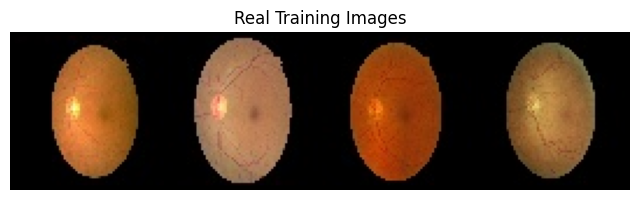

In [96]:

"""transform = transforms.Compose([transforms.ToTensor()])
class cstm_Dataset():
    def __init__(self,transform=None):
        root_dir=r'/kaggle/input/gan-test-data/Image_DATA/GAN_input/64x64/original'
        self.image_paths = [os.path.join(root_dir, img) for img in os.listdir(root_dir)]
            
    def __len__(self):
        return(len(self.image_paths))
    
    def __getitem__(self,idx):
        optic=cv2.imread(self.image_paths[idx])
        optic=cv2.resize(optic,(64,64))
        optic=cv2.cvtColor(optic, cv2.COLOR_BGR2RGB)
        optic=transform(optic)#.to(device)
        
        return optic

dataset=cstm_Dataset()

# Dataloader
dataloader = torch.utils.data.DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)"""

# Data preprocessing
dataset = dset.ImageFolder(root=r'/kaggle/input/gan-test-data/Image_DATA/Test',
                     transform=transforms.Compose([
                     transforms.Resize(X_DIM),
                     transforms.ToTensor(),
                     transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
                     ]))

# Dataloader
dataloader = torch.utils.data.DataLoader(dataset, batch_size=BATCH_SIZE, drop_last=True,
                                         shuffle=True, num_workers=4)

 # Plot some training images
real_batch = next(iter(dataloader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Real Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device), padding=2, normalize=True).cpu(),(1,2,0)))
plt.show()  

generator(
  (deconv1): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1))
  (deconv1_bn): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (deconv2): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (deconv2_bn): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (deconv3): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (deconv3_bn): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (deconv4): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (deconv4_bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (deconv5): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
)
discriminator(
  (conv1): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (conv2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
 

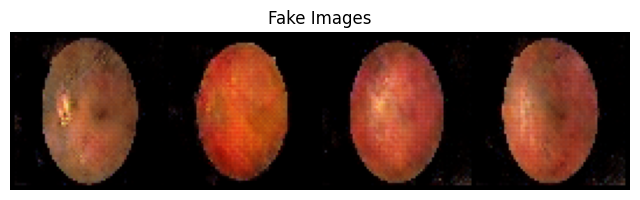

[51/2000][0/263]	Loss_D: 0.0315	Loss_G: 4.4739	D(x): 1.0000	D(G(z)): 0.0309 / 0.0120
[52/2000][0/263]	Loss_D: 0.2198	Loss_G: 3.5280	D(x): 0.8236	D(G(z)): 0.0124 / 0.0310
[53/2000][0/263]	Loss_D: 0.0554	Loss_G: 4.0536	D(x): 1.0000	D(G(z)): 0.0529 / 0.0222
[54/2000][0/263]	Loss_D: 0.0979	Loss_G: 4.4772	D(x): 0.9995	D(G(z)): 0.0927 / 0.0121
[55/2000][0/263]	Loss_D: 0.0275	Loss_G: 4.2023	D(x): 1.0000	D(G(z)): 0.0270 / 0.0158
[56/2000][0/263]	Loss_D: 0.0583	Loss_G: 4.6626	D(x): 0.9943	D(G(z)): 0.0508 / 0.0154
[57/2000][0/263]	Loss_D: 0.0062	Loss_G: 6.4472	D(x): 0.9999	D(G(z)): 0.0061 / 0.0019
[58/2000][0/263]	Loss_D: 0.0562	Loss_G: 3.7894	D(x): 0.9987	D(G(z)): 0.0533 / 0.0228
[59/2000][0/263]	Loss_D: 1.0285	Loss_G: 5.0517	D(x): 1.0000	D(G(z)): 0.5403 / 0.0885
[60/2000][0/263]	Loss_D: 0.8662	Loss_G: 4.2322	D(x): 0.9989	D(G(z)): 0.5070 / 0.0187
[61/2000][0/263]	Loss_D: 0.0548	Loss_G: 4.3424	D(x): 1.0000	D(G(z)): 0.0533 / 0.0137
[62/2000][0/263]	Loss_D: 1.1162	Loss_G: 1.8361	D(x): 0.5203	D(G(z

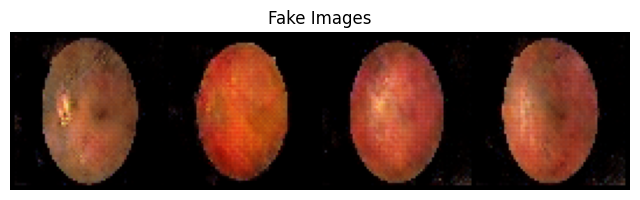

[101/2000][0/263]	Loss_D: 0.0126	Loss_G: 5.2237	D(x): 1.0000	D(G(z)): 0.0126 / 0.0055
[102/2000][0/263]	Loss_D: 0.0051	Loss_G: 5.8477	D(x): 1.0000	D(G(z)): 0.0051 / 0.0029
[103/2000][0/263]	Loss_D: 0.0129	Loss_G: 4.8399	D(x): 1.0000	D(G(z)): 0.0128 / 0.0080
[104/2000][0/263]	Loss_D: 0.0065	Loss_G: 6.7571	D(x): 1.0000	D(G(z)): 0.0065 / 0.0043
[105/2000][0/263]	Loss_D: 0.0058	Loss_G: 5.6592	D(x): 1.0000	D(G(z)): 0.0058 / 0.0037
[106/2000][0/263]	Loss_D: 0.0422	Loss_G: 3.7016	D(x): 1.0000	D(G(z)): 0.0408 / 0.0294
[107/2000][0/263]	Loss_D: 0.0227	Loss_G: 5.4315	D(x): 0.9895	D(G(z)): 0.0118 / 0.0044
[108/2000][0/263]	Loss_D: 0.0131	Loss_G: 6.3172	D(x): 1.0000	D(G(z)): 0.0130 / 0.0020
[109/2000][0/263]	Loss_D: 0.0122	Loss_G: 5.1891	D(x): 0.9998	D(G(z)): 0.0119 / 0.0058
[110/2000][0/263]	Loss_D: 0.0131	Loss_G: 4.8884	D(x): 0.9995	D(G(z)): 0.0125 / 0.0075
[111/2000][0/263]	Loss_D: 0.0045	Loss_G: 5.7610	D(x): 1.0000	D(G(z)): 0.0045 / 0.0032
[112/2000][0/263]	Loss_D: 0.0277	Loss_G: 5.3184	D(x): 

In [97]:
# Training

# Create the generator
netG = generator()
# netG = nn.DataParallel(netG)
netG.to(device)
print(netG)

# Create the discriminator
netD = discriminator()
# netD = nn.DataParallel(netD)
netD.to(device)
print(netD)

# Create batch of latent vectors that I will use to visualize the progression of the generator
viz_noise = noise#torch.randn(BATCH_SIZE, Z_DIM, 1, 1, device=device)

# Initialize BCELoss function
criterion = nn.BCELoss()

# Setup Adam optimizers for both G and D
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(0.5, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(0.5, 0.999))

# Training Loop

# Lists to keep track of progress
img_list = []
G_losses = []
D_losses = []
iters = 0

if __name__=='__main__':
    print("Starting Training Loop...")
    #netG.load_state_dict(torch.load('/kaggle/input/weights/generator.weight'))#,map_location=torch.device('cpu')
    #netD.load_state_dict(torch.load('/kaggle/input/weights/discriminator.weight'))#,map_location=torch.device('cpu')
    #netG.load_state_dict(torch.load('/kaggle/working/generator.weight'))#,map_location=torch.device('cpu')
    #netD.load_state_dict(torch.load('/kaggle/working/discriminator.weight'))#,map_location=torch.device('cpu')
    flag=0
    for epoch in range(EPOCH_NUM):
        for i, data in enumerate(dataloader, 0):
            # (1) Update the discriminator with real data
            netD.zero_grad()
            # Format batch
            real_cpu = data[0].to(device)
            b_size = real_cpu.size(0)
            #print(b_size)

            label = torch.full((b_size,), REAL_LABEL, dtype=torch.float, device=device)
            #print('real_label: ',label.shape)
            # Forward pass real batch through D
            output = netD(real_cpu).view(-1)
            #print(output.shape)

            # Calculate loss on all-real batch
            errD_real = criterion(output, label)
            # Calculate gradients for D in backward pass
            errD_real.backward(retain_graph=True)
            D_x = output.mean().item()

            # (2) Update the discriminator with fake data
            
            # Generate batch of latent vectors
            #noise = torch.randn(b_size, Z_DIM, 1, 1, device=device)
            
            # Generate fake image batch with G
            fake = netG(noise)
            label.fill_(FAKE_LABEL)
            #print('fake_label: ',label.shape)
            # Classify all fake batch with D
            output = netD(fake.detach()).view(-1)
            # Calculate D's loss on the all-fake batch
            errD_fake = criterion(output, label)
            # Calculate the gradients for this batch, accumulated (summed) with previous gradients
            errD_fake.backward(retain_graph=True)
            D_G_z1 = output.mean().item()
            # Compute error of D as sum over the fake and the real batches
            errD = errD_real + errD_fake
            # Update D
            optimizerD.step()

            # (3) Update the generator with fake data
            netG.zero_grad()
            label.fill_(REAL_LABEL)  # fake labels are real for generator cost
            # Since we just updated D, perform another forward pass of all-fake batch through D
            output = netD(fake).view(-1)
            # Calculate G's loss based on this output
            errG = criterion(output, label)
            # Calculate gradients for G
            errG.backward(retain_graph=True)
            D_G_z2 = output.mean().item()
            # Update G
            optimizerG.step()

            # Output training stats
            if i % 263 == 0:
                print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                      % (epoch+1, EPOCH_NUM, i, len(dataloader),
                         errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))
                

            # Save Losses for plotting later
            G_losses.append(errG.item())
            D_losses.append(errD.item())
        
        if ((epoch+1)%5==0):
            avg_G_Loss=sum(G_losses[-5:])/5
            avg_D_Loss=sum(D_losses[-5:])/5
            if avg_G_Loss>=40 or avg_D_Loss>=5:
                print('Exited')
                break
        
        if ((epoch+1)%50==0):
            print("........Saving.......")
            torch.save(netG.state_dict(), '/kaggle/working/generator.weight')
            torch.save(netD.state_dict(), '/kaggle/working/discriminator.weight')
            
            with torch.no_grad():
                fake = netG(noise).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))
            # Plot some fake images
            real_batch = next(iter(img_list))
            plt.figure(figsize=(8,8))
            plt.axis("off")
            plt.title("Fake Images")
            plt.imshow(np.transpose(vutils.make_grid(real_batch.to(device), padding=2, normalize=True).cpu(),(1,2,0)))
            plt.show()

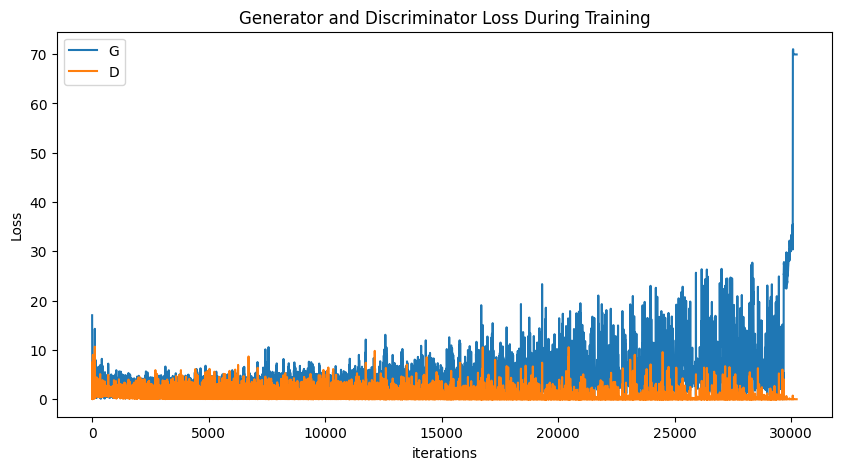

In [98]:
#plot loss graph

plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

torch.Size([4, 100, 1, 1])


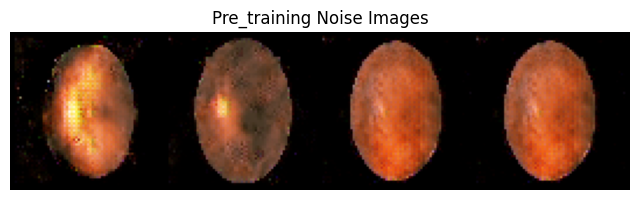

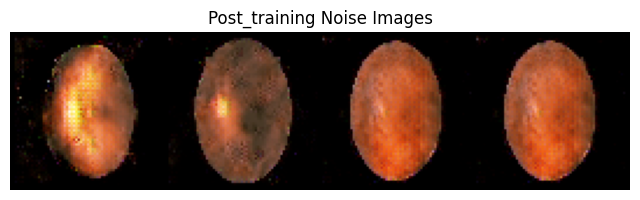

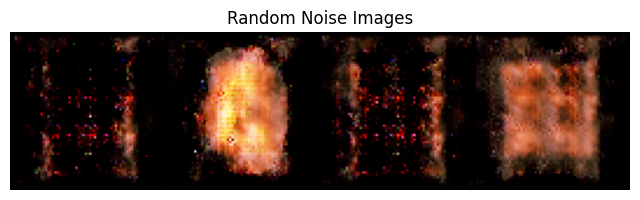

In [99]:
# Generate image
def show_img(img_tensor):
    img_tensor = np.moveaxis(img_tensor, 0, -1)
    #img_tensor=np.transpose(img_tensor,(1,2,0))
    print('Output Image Size: ',img_tensor.shape)

    m = np.min(img_tensor)
    M = np.max(img_tensor)

    img_tensor = (img_tensor-m)/(M-m)

    img_tensor = 255*img_tensor

    img_tensor = np.array(img_tensor, dtype='uint8')

    plt.imshow(img_tensor)
    plt.show()

def display_image(dataloader,str):
    # Plot some training images
    Data=dataloader #next(iter(dataloader))
    #print(Data)
    plt.figure(figsize=(8,8))
    plt.axis("off")
    plt.title(f"{str} Images")
    plt.imshow(np.transpose(vutils.make_grid(Data[:],nrow=4, padding=2, normalize=True).cpu(),(1,2,0)))
    plt.show() 
    
if __name__=='__main__':
    netG = generator()
    #netG.load_state_dict(torch.load('/kaggle/input/weights/generator.weight'))#,map_location=torch.device('cpu')
    netG.load_state_dict(torch.load('/kaggle/working/generator.weight'))
    netG.to(device)
    rand_noise = torch.randn(BATCH_SIZE, Z_DIM, 1, 1, device=device)
    
    """with torch.no_grad():
        print(noise.shape)
        fake = netG(noise).detach().cpu().numpy()
        rand_fake = netG(rand_noise).detach().cpu().numpy()
        print(fake[0].shape)    
        
    print('Fake')
    show_img(fake[0])
    show_img(fake[1])
    show_img(fake[2])
    show_img(fake[3])
    
    print('\nRandom Fake')
    show_img(rand_fake[0])
    show_img(rand_fake[1])
    show_img(rand_fake[2])
    show_img(rand_fake[3])"""
    
    with torch.no_grad():
        print(noise.shape)
        pre_fake = netG(viz_noise).detach().cpu()
        post_fake = netG(noise).detach().cpu()
        rand_fake = netG(rand_noise).detach().cpu()
        #print(fake[0].shape)
    
    #Show Training Images
    display_image(pre_fake,'Pre_training Noise')
    display_image(post_fake,'Post_training Noise')
    display_image(rand_fake,'Random Noise')